# Feature Extraction & Embedding

Once our text has been preprocessed, we need to transform them into features that can be used for modelling. In here we will learn all techniques for **extracting relevant features** from text data.

In this jupyter notebook we will go through 6 different topics:
1. **Bag of Words (BoW)**
2. **TF-IDF**
3. **One-Hot Encoding**
4. **Word Embedding Using Word2Vec**
5. **GloVe (Global Vector for Word Representation)**
6. **t-SNE (t-Distributed Stochastic Neighbour Embedding)**

<hr>

## 1. Bag of Words (BoW)

The **bag of words (BoW)** model is a simplifying representation used in natural language processing and information retrieval. In this model, a text is represented as the bag of its words, disregarding grammar and even word order but keeping multiplicity. (Wikipedia)

<img src="./assets/bow.png">

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import re

In [2]:
# Sample text
text = ["Little House on the Prairie",
        "Mary had a Little Lamb",
        "The Silence of the Lambs",
        "Twinkle Twinkle Little Star"]
print(text)

['Little House on the Prairie', 'Mary had a Little Lamb', 'The Silence of the Lambs', 'Twinkle Twinkle Little Star']


Before getting the Bag of Words, we need to preprocess the whole text. Afterward we need to collect the unique words. So in general **corpus** is defined as a set of documents and **vocabulary** as unique words in our corpus.

<img src="./assets/corpus_vocabs.png">


In [3]:
# Preprocessing the text
def preprocess_text(list_of_texts):

    # Lowercasing the text
    text = list_of_texts.lower()

    # Removing the punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # Converting to tokens
    tokens = word_tokenize(text)

    # Removing the stopwords
    tokens = [i_token for i_token in tokens if i_token not in stopwords.words("english")]

    # Apply stemmer
    stemmed = [PorterStemmer().stem(i_token) for i_token in tokens]

    # Apply lemmizer
    lemmtized = [WordNetLemmatizer().lemmatize(i_token, pos="n") for i_token in stemmed]
    lemmtized = [WordNetLemmatizer().lemmatize(i_token, pos="v") for i_token in lemmtized]

    return lemmtized

In [4]:
# Converting from a list of strings into one string
text = " ".join(text)

# Apply preprocessing function to our text
tokens = preprocess_text(text)

print("Preprocessed text: \n", tokens)

Preprocessed text: 
 ['littl', 'hous', 'prairi', 'mari', 'littl', 'lamb', 'silenc', 'lamb', 'twinkl', 'twinkl', 'littl', 'star']


In [5]:
# Getting the vocabularies
vocabularies = np.unique(tokens)
print(vocabularies)

['hous' 'lamb' 'littl' 'mari' 'prairi' 'silenc' 'star' 'twinkl']


Arrange the vocabulary in order to form the vector element position or column of our table. Also assume each document is a row. Then count the number of occurrence of each word in each document and enter the value in the respective column. At this stage we can think of this as a **Document-Term Matrix** which it represents the relationship between documents in rows, and words or terms in columns.

<img src="./assets/document-term matrix.png">

In [6]:
# document-term matrix function
def document_term_matrix(list_of_new_sentences, vocabularies):
    
    # Initializing an empty list for all of the document-term matrix
    list_of_document_term_matrix = []
    
    for i_new_sentence in list_of_new_sentences:

        # Preprocess the sentence
        new_tokens = preprocess_text(i_new_sentence)

        # Initializing a zeros array
        dtm = np.zeros(len(vocabularies))

        # Iterating through tokens
        for i_token in new_tokens:

            # Iterating through vocabularies
            for index, i_vocab in enumerate(vocabularies):

                # Add 1 if the token is inside vocabulary
                if i_vocab == i_token:
                    dtm[index] += 1
                    
        # Append the document-term matrix to the list of document-term matrix
        list_of_document_term_matrix.append(dtm)

    # Convert to dataframe
    dtm = pd.DataFrame(data = list_of_document_term_matrix,index = [list_of_new_sentences], columns = vocabularies)
    
    return dtm

In [7]:
# List of new sentences that we will apply the document-term matrix
list_of_new_sentences = ["Little House on the Prairie",
                         "Mary had a Little Lamb",
                         "The Silence of the Lambs",
                         "Twinkle Twinkle Little Star"]

# Apply the document-term matrix
dtm = document_term_matrix(list_of_new_sentences, vocabularies)
dtm

,hous,lamb,littl,mari,prairi,silenc,star,twinkl
Little House on the Prairie,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
Mary had a Little Lamb,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
The Silence of the Lambs,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Twinkle Twinkle Little Star,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0


**RESOURCES:**
1. <a href="https://www.youtube.com/watch?v=OGK9SHt8SWg">Bag of Words - Intro to Machine Learning</a>
2. <a href="http://www.insightsbot.com/blog/R8fu5/bag-of-words-algorithm-in-python-introduction">Bag of Words Algorithm in Python Introduction</a>
3. <a href="https://medium.freecodecamp.org/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04">An introduction to Bag of Words and how to code it in Python for NLP</a>

<hr>

## 2. TF-IDF

One limitation of BoW is that it treats every word as being equally important. Even though some words occur frequently within a corpus.

<img src="./assets/document-term matrix.png">

The solution is to first count the number of documents in which each word occur (this is called document frequency). 

<img src="./assets/tf_1.png">

Then we have to divide the term frequency by the document frequency of that term. 

<img src="./assets/tf_2.png">

Now we have a metric that is proportional to the frequency of occurrence of a term in a document. And inversely promotional to the number of documents it appears in.

<img src="./assets/tf_3.png">


In [8]:
# Copying the document-term matrix
tfidf = dtm.copy()

# Iterating through column names
for index_1, i_col_name in enumerate(tfidf.columns):
    
    # Get the column
    i_col = tfidf.iloc[:, index_1]
    
    # Get the sum of column
    i_col_sum = sum(i_col)
    
    # Iterating through items in a column
    for index_2, i_item in enumerate(i_col):
        
        # Dividing each item to the whol sum of column
        tfidf.iloc[index_2, index_1] = tfidf.iloc[index_2, index_1] / i_col_sum

In [9]:
tfidf

,hous,lamb,littl,mari,prairi,silenc,star,twinkl
Little House on the Prairie,1.0,0.0,0.333333,0.0,1.0,0.0,0.0,0.0
Mary had a Little Lamb,0.0,0.5,0.333333,1.0,0.0,0.0,0.0,0.0
The Silence of the Lambs,0.0,0.5,0.000000,0.0,0.0,1.0,0.0,0.0
Twinkle Twinkle Little Star,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,1.0


**RESOURCES:**
1. <a href="http://www.tfidf.com/">Tf-idf: A Single-Page Tutorial</a>
2. <a href="https://github.com/mayank408/TFIDF">Implementation of TF-IDF using sklearn library</a>

<hr>

## 3. One-Hot Encoding

In **one-hot encoding**, We treat each word like a class, and assign 1 in a single pre-determined position for that word and 0 anywhere else.


<img src="./assets/one_hot.png">

In [10]:
# One hot encoding function
def one_hot_encoding(vocabularies):
    
    # Initializin a zero array
    one_hot_encoded = np.zeros([len(vocabularies), len(vocabularies)])
    
    # Convert to dataframe
    one_hot_encoded = pd.DataFrame(data = one_hot_encoded, index = [vocabularies], columns = [vocabularies])
    
    # Set 1 to if the word exist in the corresponding place
    for i_vocab in vocabularies:
        one_hot_encoded.loc[i_vocab, i_vocab] = 1
        
    return one_hot_encoded

In [11]:
# Apply the one hot encoding to our vocabularies
one_hot_encoded = one_hot_encoding(vocabularies)
one_hot_encoded

,hous,lamb,littl,mari,prairi,silenc,star,twinkl
hous,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lamb,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
littl,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
mari,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
prairi,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
silenc,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
star,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
twinkl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
# Get the one hot encoded of the word "star"
one_hot_encoded.loc["star"].values

array([[0., 0., 0., 0., 0., 0., 1., 0.]])

**RESOURCES:**
1. <a href="https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/">How to One Hot Encode Sequence Data in Python</a>
2. <a href="https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f">What is One Hot Encoding? Why And When do you have to use it?</a>

<hr>

## 4. Word Embedding Using Word2Vec

**Word Embedding** is a language modeling technique used for mapping words to vectors of real numbers. It represents words or phrases in vector space with several dimensions. Word embeddings can be generated using various methods like neural networks, co-occurrence matrix, probabilistic models, etc.

**Word2Vec consists** of models for generating word embedding. These models are shallow two layer neural networks having one input layer, one hidden layer and one output layer. Word2Vec utilizes two architectures :

1. **CBOW (Continuous Bag of Words):** CBOW model predicts the current word given context words within specific window. The input layer contains the context words and the output layer contains the current word. The hidden layer contains the number of dimensions in which we want to represent current word present at the output layer.

2. **Skip Gram:** Skip gram predicts the surrounding context words within specific window given current word. The input layer contains the current word and the output layer contains the context words. The hidden layer contains the number of dimensions in which we want to represent current word present at the input layer.

The given text is taken from <a href="https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/">geeksforgeeks</a>.

<img src="./assets/word_embedding.png">

In [15]:
# Importing the libraries
import urllib.request  
import bs4 as bs  
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Get data in the given url
data = urllib.request.urlopen('https://en.wikipedia.org/wiki/Artificial_intelligence').read()

# Remove the html tags
data = bs.BeautifulSoup(data,'html5lib')

# Get all paragraphs
paragraphs = data.find_all('p')

# Covert list of bs4 into list of strings
article = [i.text.strip() for i in paragraphs]

In [24]:
# Preprocessing the text
def preprocess_text(list_of_texts):

    # Lowercasing the text
    text = list_of_texts.lower()

    # Removing the punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # Converting to tokens
    tokens = word_tokenize(text)

    # Removing the stopwords
    tokens = [i_token for i_token in tokens if i_token not in stopwords.words("english")]

    # Apply stemmer
    stemmed = [PorterStemmer().stem(i_token) for i_token in tokens]

    # Apply lemmizer
    lemmtized = [WordNetLemmatizer().lemmatize(i_token, pos="n") for i_token in stemmed]
    lemmtized = [WordNetLemmatizer().lemmatize(i_token, pos="v") for i_token in lemmtized]
    
    return lemmtized

# Apply prerpcoessing to our text
preprocessed_tokens = [preprocess_text(i) for i in article]

In [25]:
# Apply Word2Vect (CBOW) to our preprocessed data
word2vec = Word2Vec(preprocessed_tokens, 
                    sg = 0,     # 1 for skip-gram; 0 for CBOW.
                    size=200, 
                    window=5, 
                    min_count=2, 
                    iter=5)

In [26]:
# Get all vocabularies
vocabulary = word2vec.wv.vocab  

In [31]:
# Check Word2Vec for the word "artifici"
v1 = word2vec.wv['artifici']

In [32]:
# Get similar words as "intelligence"
sim_words = word2vec.wv.similar_by_word('intellig', topn=10)  
sim_words

[('ai', 0.9010429382324219),
 ('human', 0.876861572265625),
 ('use', 0.8743880987167358),
 ('artifici', 0.8604949116706848),
 ('comput', 0.8595353960990906),
 ('machin', 0.8574860095977783),
 ('includ', 0.8559404611587524),
 ('research', 0.8515568375587463),
 ('ethic', 0.8465765714645386),
 ('could', 0.8454834222793579)]

In [33]:
# Get words that are similar to "human" but dissimilar to "machine"
result = word2vec.wv.most_similar(positive=["human"], negative=["machin"])
result

[('signal', 0.1850748509168625),
 ('next', 0.1746460199356079),
 ('heavili', 0.1717621088027954),
 ('featur', 0.16493657231330872),
 ('potenti', 0.16120567917823792),
 ('cybernet', 0.15793409943580627),
 ('implicit', 0.1561574935913086),
 ('frequent', 0.1556098908185959),
 ('computation', 0.15404289960861206),
 ('blue', 0.15155860781669617)]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


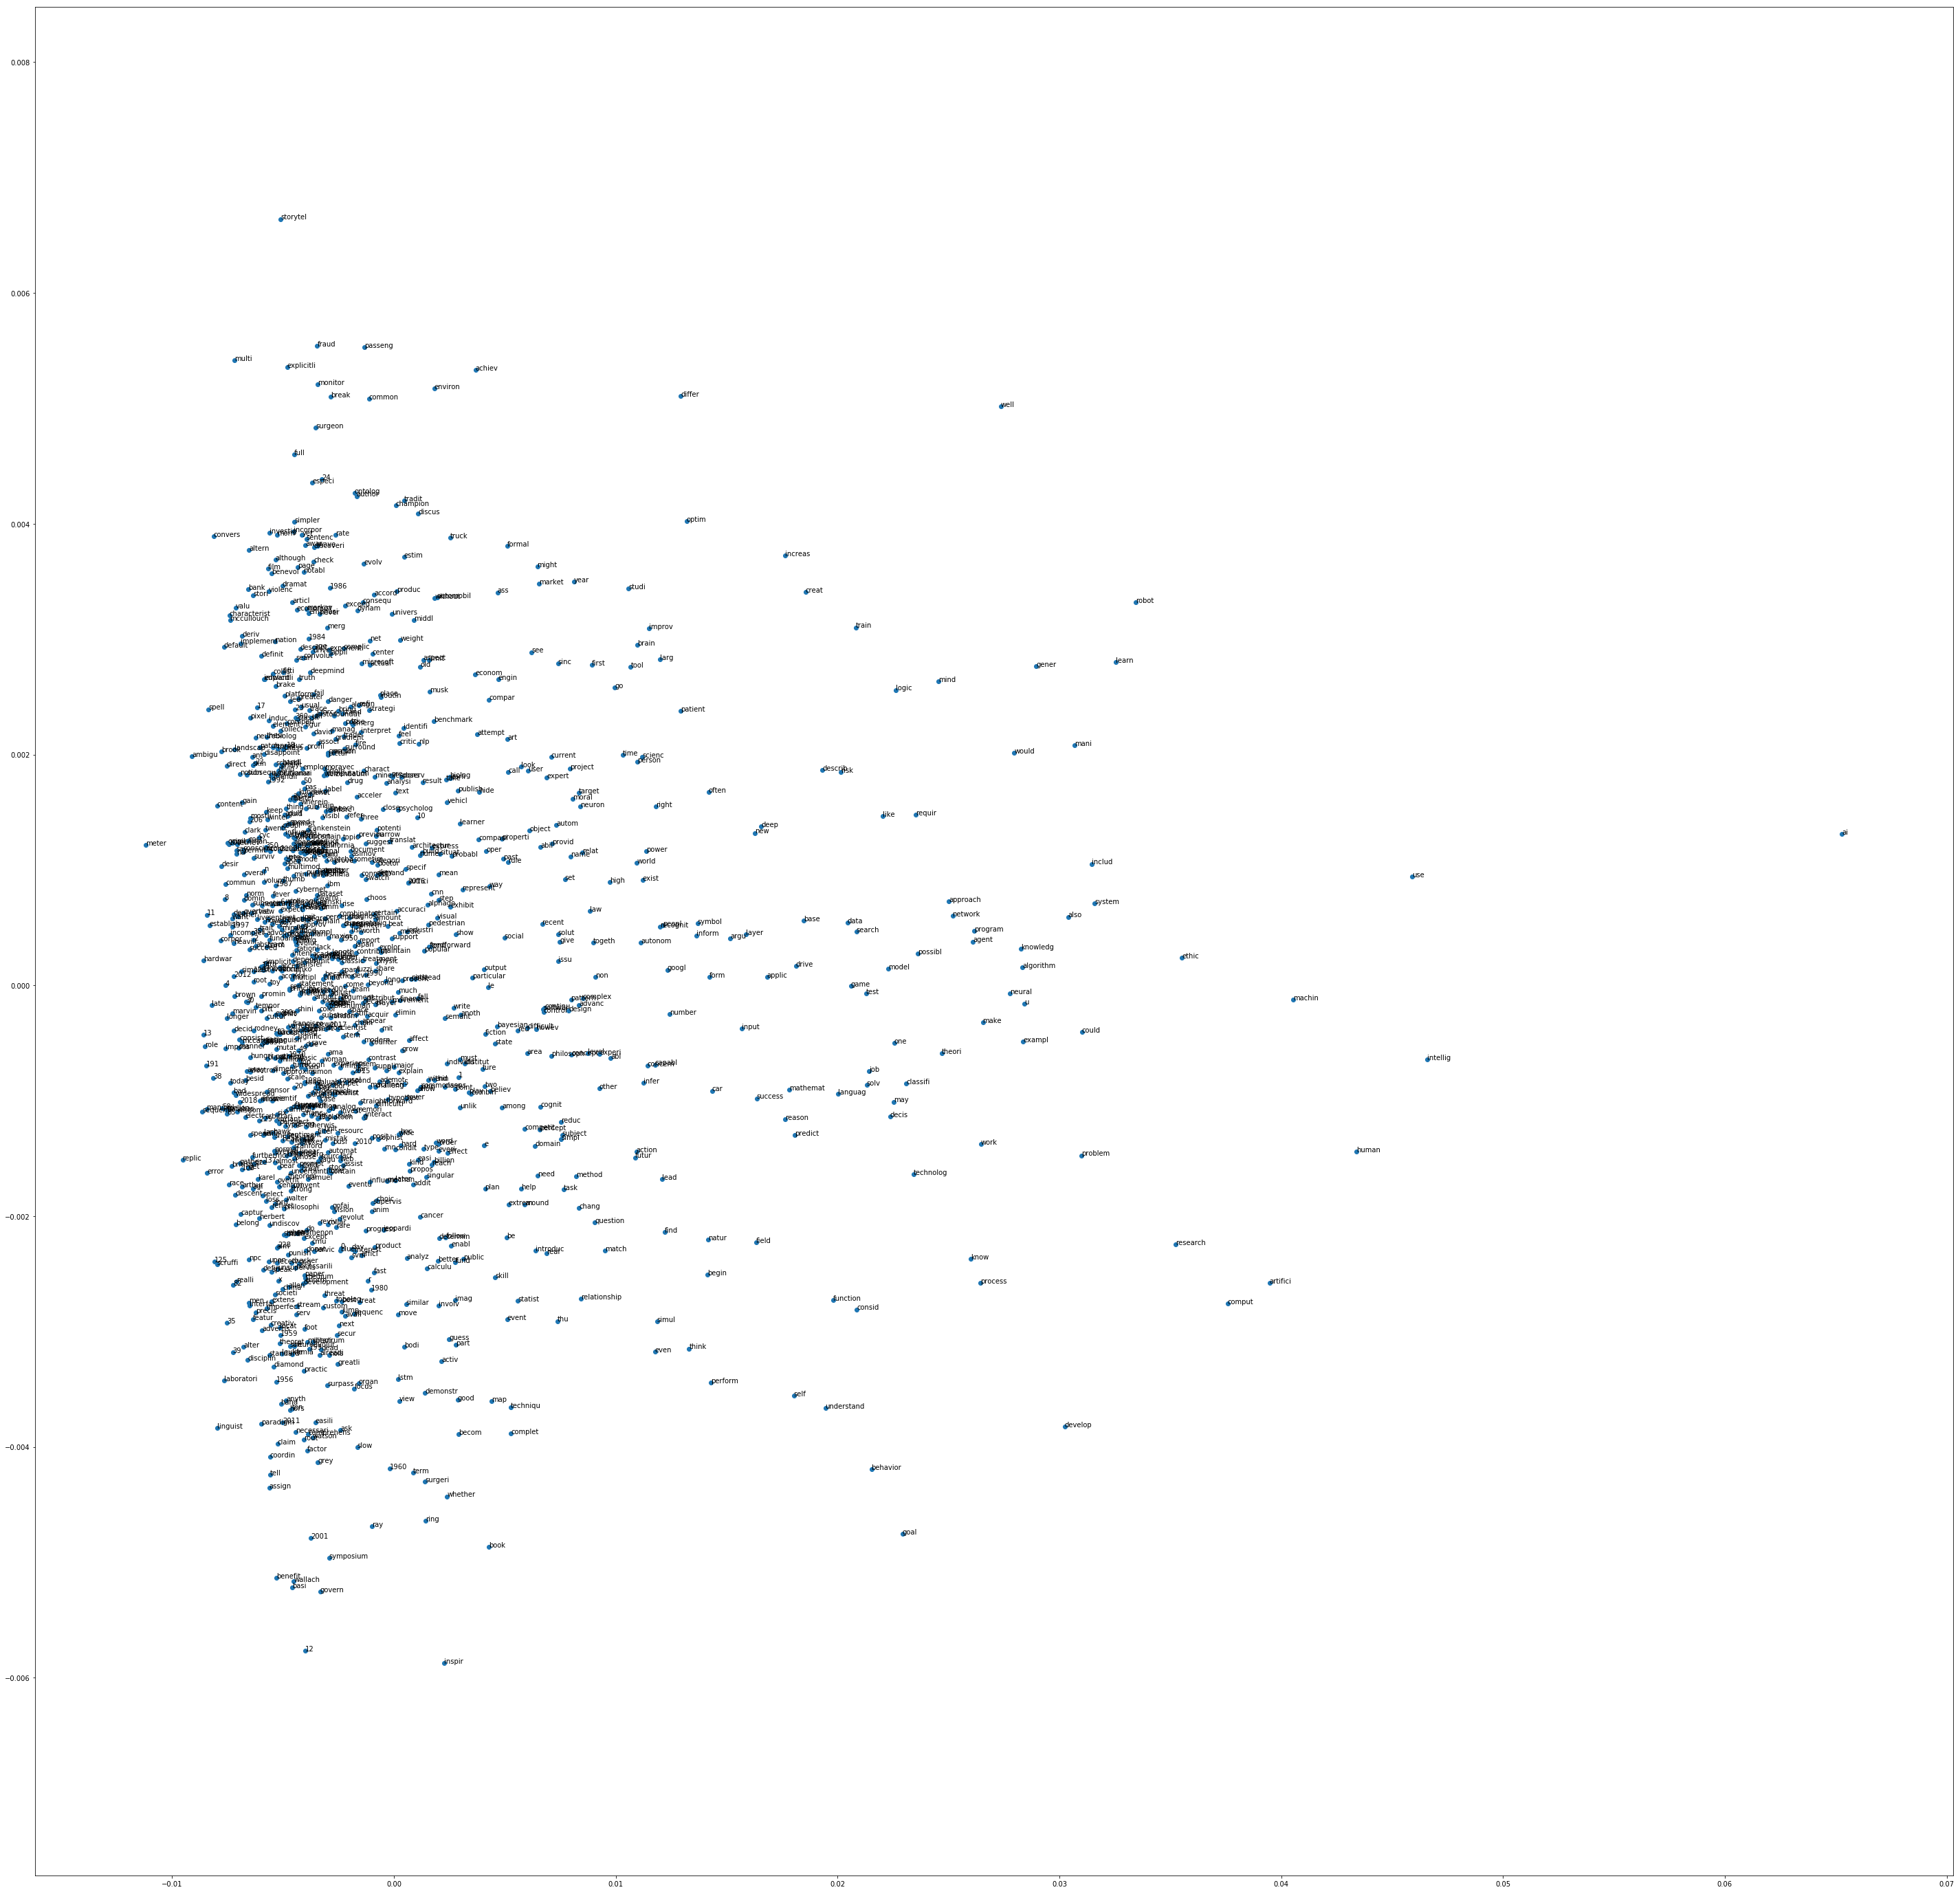

In [34]:
# Retrieve all of the vectors
X = word2vec[word2vec.wv.vocab]

# Applying PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Plot Word Vectors Using PCA
plt.figure(figsize = (50, 50))
plt.scatter(result[:, 0], result[:, 1])
words = list(word2vec.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

**RESOURCES:**

1. <a href="https://radimrehurek.com/gensim/models/word2vec.html">Official documentation of Word2Vec in Gensim</a>
2. <a href="https://stackabuse.com/implementing-word2vec-with-gensim-library-in-python/">Implementing Word2Vec with Gensim Library in Python</a>
3. <a href="https://towardsdatascience.com/word-embeddings-exploration-explanation-and-exploitation-with-code-in-python-5dac99d5d795">Word embeddings: exploration, explanation, and exploitation (with code in Python)
</a>
4. <a href="https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/">Python | Word Embedding using Word2Vec</a>

<hr>

## 5. GloVe (Global Vector for Word Representation)

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In here we use a <a href="https://nlp.stanford.edu/projects/glove/">dataset from Stanford</a> which in the website is called glove.6B.zip. You can download it stright from <a href="http://nlp.stanford.edu/data/glove.6B.zip">here</a>

In [21]:
# Importing the libraries
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [22]:
# Convert the file to word2vec format
glove_input_file = './glove.6B/glove.6B.100d.txt'
word2vec_output_file = './glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [23]:
# load the Stanford GloVe model
filename = './glove.6B/glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [24]:
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.7698541283607483)]


**RESOURCES:**
1. <a href="https://machinelearningmastery.com/develop-word-embeddings-python-gensim/">How to Develop Word Embeddings in Python with Gensim<a>
2. <a href="https://nlp.stanford.edu/pubs/glove.pdf">GloVe: Global Vectors for Word Representation</a>

<hr>

## 6. t-SNE (t-Distributed Stochastic Neighbour Embedding)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a (prize-winning) technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

In [25]:
# Importing the libraries
import numpy as np
from keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from helper import fashion_scatter

%matplotlib inline

Using TensorFlow backend.


In [26]:
# Loading the dataset
((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()

print("Training set shape: ", X_train.shape)
print("Test set shape: ", X_test.shape)

Training set shape:  (60000, 28, 28)
Test set shape:  (10000, 28, 28)


In [27]:
# Subset only the first 20k in your training set
x_subset = X_train[0:20000]
y_subset = y_train[0:20000]

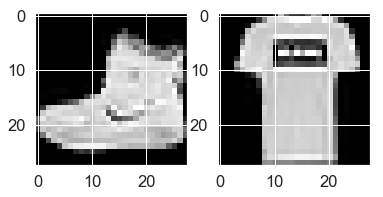

In [28]:
# Visualize first two images in the training set
plt.subplot(121)
plt.imshow(x_subset[0], cmap="gray")

plt.subplot(122)
plt.imshow(x_subset[1], cmap="gray")

In [29]:
# Reshape the training set and test set from (20000, 28, 28) to (20000, 28*28)
x_subset = x_subset.reshape(20000, 28*28)

Based on <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">Scikit-learn's documentation</a>, It suggests us to apply PCA before aaplying t-SNE. So that's what we are going to do.

Scikit-learn's documentation of t-SNE explicitly states that:

<i>It is highly recommended to use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.</i>

In [30]:
# Apply PCA to our training set
pca = PCA(n_components = 50)
pca_result = pca.fit_transform(x_subset)

In [31]:
# Apply t-SNE to the PCA result
pca_tsne = TSNE(random_state=123).fit_transform(pca_result)

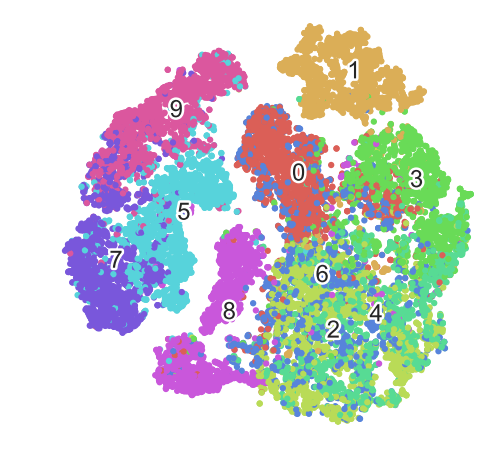

In [32]:
fashion_scatter(pca_tsne, y_subset)
plt.show()

**RESOURCES:**
1. <a href="https://www.datacamp.com/community/tutorials/introduction-t-sne">Introduction to t-SNE</a>
2. <a href="https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b">Visualizing high-dimensional datasets using PCA and t-SNE in Python</a>
3. <a href="https://lvdmaaten.github.io/tsne/">t-SNE by Laurens van der Maaten (t-SNE inventor)</a>